In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('wine_quality.csv')
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [3]:
y = df['quality']
features = df.drop(columns = ['quality'])


In [4]:
#Data transformation
from sklearn.preprocessing import StandardScaler
standard_scaler_fit = StandardScaler().fit(features)
X = standard_scaler_fit.transform(features)

In [5]:
#Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)


In [6]:
#Fit a logistic regression classifier without regularization
from sklearn.linear_model import LogisticRegression

#set the penalty parameter to 'none'
clf_no_reg = LogisticRegression(penalty = 'none') 
clf_no_reg.fit(X_train, y_train)

LogisticRegression(penalty='none')

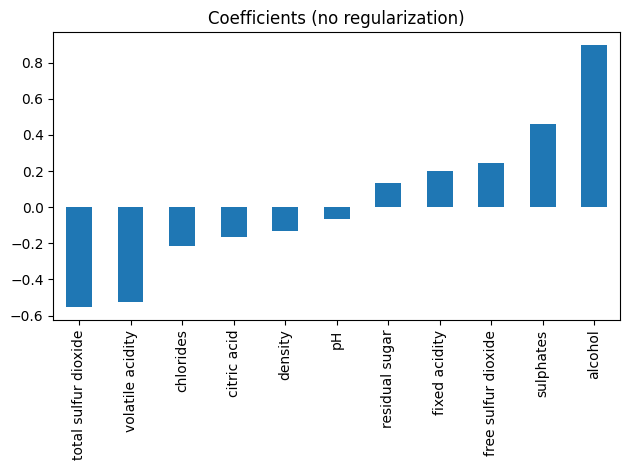

<Figure size 640x480 with 0 Axes>

In [7]:
#Plot the coefficients
predictors = features.columns
coefficients = clf_no_reg.coef_.ravel()
coef = pd.Series(coefficients,predictors).sort_values()
coef.plot(kind='bar', title = 'Coefficients (no regularization)')
plt.tight_layout()
plt.show()
plt.clf()

In [8]:
#Training and test performance
from sklearn.metrics import f1_score
y_pred_test = clf_no_reg.predict(X_test)
y_pred_train = clf_no_reg.predict(X_train)
#weighted mean of precision and recall: f1 score
print('Training Score', f1_score(y_train, y_pred_train))
print('Testing Score', f1_score(y_test, y_pred_test))

Training Score 0.7727598566308242
Testing Score 0.7266666666666667


In [9]:
#Default Implementation (L2-regularized)
clf_default = LogisticRegression()
clf_default.fit(X_train, y_train)


LogisticRegression()

In [10]:
#Ridge Scores
y_pred_train_ridge = clf_default.predict(X_train)
y_pred_test_ridge = clf_default.predict(X_test)
print(' Ridge-regularized Training Score', f1_score(y_train, y_pred_train_ridge))
print('Ridge-regularized Testing Score', f1_score(y_test, y_pred_test_ridge))

 Ridge-regularized Training Score 0.7727598566308242
Ridge-regularized Testing Score 0.7266666666666667


In [11]:
#Coarse-grained hyperparameter tuning
training_array = []
test_array = []
C_array = [0.0001, 0.001, 0.01, 0.1, 1]

for x in C_array:
    clf = LogisticRegression(C = x )
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    training_array.append(f1_score(y_train, y_pred_train))
    test_array.append(f1_score(y_test, y_pred_test))

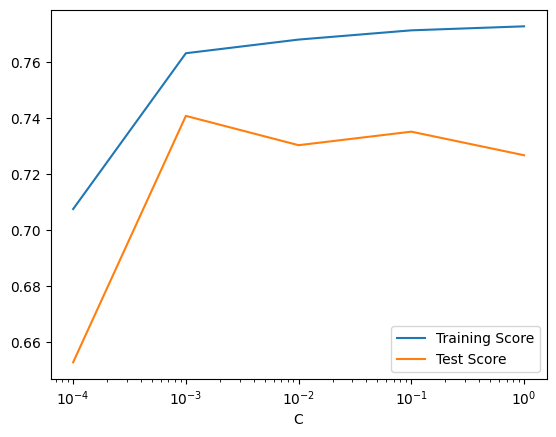

<Figure size 640x480 with 0 Axes>

In [12]:
#Plot training and test scores as a function of C
plt.plot(C_array,training_array, label = 'Training Score')
plt.plot(C_array,test_array, label = 'Test Score')
plt.xscale('log')
plt.xlabel('C')
plt.legend()
plt.show()
plt.clf()

In [13]:
#Making a parameter grid for GridSearchCV
C_array  = np.logspace(-4, -2, 100)
#Making a dict to enter as an input to param_grid
tuning_C = {'C':C_array}

#Implementing GridSearchCV with l2 penalty
from sklearn.model_selection import GridSearchCV
clf_gs = LogisticRegression()
gs = GridSearchCV(clf_gs, param_grid = tuning_C, scoring = 'f1', cv = 5)
gs.fit(X_train,y_train)

#Optimal C value and the score corresponding to it
print(gs.best_params_, gs.best_score_)

{'C': 0.0019630406500402726} 0.7723336222647887


In [14]:
#Validating the "best classifier"
clf_best = LogisticRegression(C = gs.best_params_['C'])
clf_best.fit(X_train,y_train)
y_pred_best = clf_best.predict(X_test)
print(f1_score(y_test,y_pred_best))

0.7407407407407408


In [15]:
#Implement L1 hyperparameter tuning with LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV
C_array = np.logspace(-2,2,100)
clf_l1 = LogisticRegressionCV(Cs=C_array, cv = 5, penalty = 'l1', scoring = 'f1', solver = 'liblinear')
clf_l1.fit(X,y)

#Optimal C value and corresponding coefficients
print('Best C value', clf_l1.C_)
print('Best fit coefficients', clf_l1.coef_)


Best C value [0.25950242]
Best fit coefficients [[ 0.1166095  -0.55636037 -0.17274708  0.03122601 -0.17322222  0.20056087
  -0.50581943  0.         -0.07040101  0.43220588  0.94101801]]


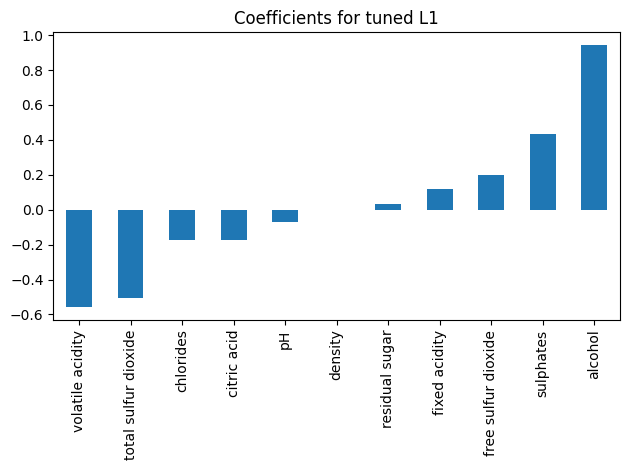

<Figure size 640x480 with 0 Axes>

In [16]:
#Plotting the tuned L1 coefficients
coefficients = clf_l1.coef_.ravel()
coef = pd.Series(coefficients,predictors).sort_values()
coef.plot(kind='bar', title = 'Coefficients for tuned L1')
plt.tight_layout()
plt.show()
plt.clf()